In [1]:
import torch
import torch.nn as nn # neural network
import torch.nn.functional as F # funcitions Relu
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [2]:
#DIRECIONES
direciones_img = {
    "alexnet" : 'Img/Alexnet',
    'vgg11' : 'Img/VGG/11',
    'vgg16' : 'Img/VGG/16',
    'resnet18' : 'Img/RESNET/18',
    'resnet34' : 'Img/RESNET/32',
    'resnet50' : 'Img/RESNET/50',
    'resnet101' : 'Img/RESNET/101',
    'inception' : 'Img/INCEPTION/V1',
    'inception_v3' : 'Img/INCEPTION/V3',
    'densenet121' : 'Img/DENSENET/121',
    'densenet169' : 'Img/DENSENET/169',
    'densenet201' : 'Img/DENSENET/201',
}

In [3]:
# Verificar si hay una GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# =============================
# =======LECTURA DATASET=======
# =============================
transformaciones = transforms.Compose([
    transforms.ToTensor()                                                               # Convierte las imágenes a tensores de PyTorch
])

# Carga las imágenes desde la carpeta --> TRAIN
carpeta_imagenes_train = "./Datasets/malevis/malevis_train_val_300x300/train"
dataset_train = datasets.ImageFolder(carpeta_imagenes_train, transform=transformaciones)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_train

# Carga las imágenes desde la carpeta --> TEST
carpeta_imagenes_test = "./Datasets/malevis/malevis_train_val_300x300/val"
dataset_test = datasets.ImageFolder(carpeta_imagenes_test, transform=transformaciones)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
dataloader_test

In [5]:
#=====================
#======MODELOS========
#=====================
model = models.alexnet(pretrained=False)

#model = models.vgg11(pretrained=False)
#model = models.vgg16(pretrained=False)

# model = models.resnet18(pretrained=False)
# model = models.resnet34(pretrained=False)
# model = models.resnet50(pretrained=False)
# model = models.resnet101(pretrained=False)

#model = models.inception(pretrained=False)
#model = models.inception_v3(pretrained=False)

# model = models.densenet121(pretrained=False)
# model = models.densenet169(pretrained=False)
# model = models.densenet201(pretrained=False)


img_dir = direciones_img['alexnet']
model = model.to(device=device)


d:\basti\Documents\dETECCION DE MALWARE\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\basti\Documents\dETECCION DE MALWARE\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Evaluación de la precisión en el conjunto de validación
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        val_accuracies.append(accuracy)
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return train_losses, val_accuracies

In [10]:
train_losses, val_accuracies = train_model( model, dataloader_train, dataloader_test, criterion, optimizer, device, num_epochs=60)

100%|██████████| 60/60 [1:01:46<00:00, 61.77s/it]


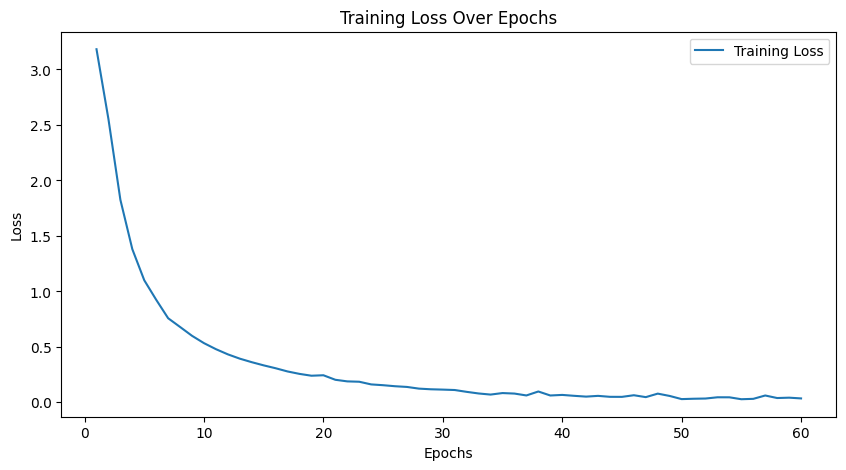

In [17]:
# Graficar la pérdida de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.savefig(img_dir + '/loss.jpeg')
plt.show()

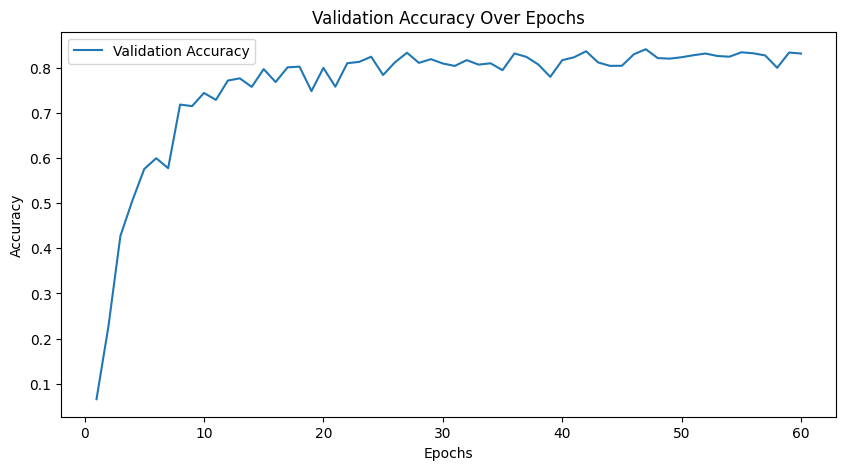

In [18]:
# Graficar la precisión de validación
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.savefig(img_dir + '/precision.jpeg')
plt.show()

In [15]:
def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calcula precisión y recall
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    # Calcula matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    return precision, recall, conf_matrix

In [19]:
precision, recall, conf_matrix = calculate_precision_recall(model, dataloader_test, device)


In [134]:
precision

0.08358708954175305

In [135]:
recall

0.2891143191572376

In [20]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(img_dir + '/matrix_confusion.jpeg')
    plt.show()


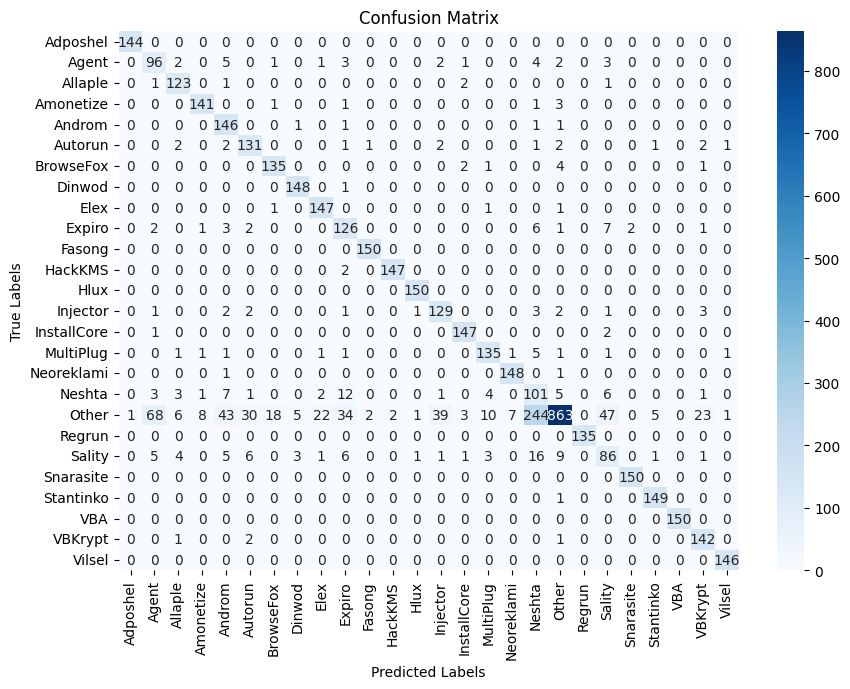

In [21]:
class_names = dataset_test.classes
plot_confusion_matrix(conf_matrix, class_names)
